In [1]:
import numpy as np
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import tensorflow as tf
import PIL.Image
import keras.backend as K

import time
import matplotlib.pyplot as plt

from keras import activations
from keras.models import load_model
from layers import LogWhiten


import feather
import pandas as pd
import matplotlib.pyplot as plt
import sunpy.cm as cm
from copy import deepcopy
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


%matplotlib inline

Using TensorFlow backend.


In [2]:
def show_image(image, grayscale = True, ax=None, title=''):
    if ax is None:
        plt.figure()
    plt.axis('off')
    
    if len(image.shape) == 2 or grayscale == True:
        if len(image.shape) == 3:
            image = np.sum(np.abs(image), axis=2)
            
        vmax = np.percentile(image, 99)
        vmin = np.min(image)

        plt.imshow(image, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
        plt.title(title)
    else:
        image = image + 127.5
        image = image.astype('uint8')
        
        plt.imshow(image)
        plt.title(title)
    
def load_image(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    
    return im - 127.5

# utility function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()*1
    x /= (x.std() + 1e-5)/1
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def relu_advanced(x):
    return K.relu(x, alpha=0.01)    

In [3]:
#filenameN = '1st_Dreamer_weights.99-1489.53'
#filenameN = '2nd_Dreamer.weights.128-1526.14'
#filenameN = '3rd_Dreamer_weights.38-482.85'
#filenameN = 'FN4_weights.204-145.56'
#filenameN = 'FN5weights.68-141.02'
#filenameN = 'FN7_Leak_weights.167-331.71'
filenameN = 'FN6_weights.197-198.27'

#filenameN = 'FN9_weights.175-255.91'
#filenameN = 'FN8_weights.90-556.06'

#filenameN  = 'FN12_weights.103-390.52'


network_model_path = filenameN +'.hdf5'
custom_objects = {"LogWhiten": LogWhiten, "relu_advanced":relu_advanced}
model = load_model(network_model_path, custom_objects=custom_objects)
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024, 1024, 8)     0         
_________________________________________________________________
log_whiten_1 (LogWhiten)     (None, 1024, 1024, 8)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1024, 1024, 16)    32768     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1024, 1024, 16)    65536     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      32768     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      65536     
__________

In [4]:
# Load an image and make the prediction
filename = '00000_AIA20120306_2324_8chnls_1024_060m'
#filename = '00681_AIA20140213_0636_8chnls_1024_096m'
#filename = '06321_AIA20150111_1728_8chnls_1024_060m'
df = feather.read_dataframe('00000_AIA20120306_2324_8chnls_1024_060m' + '.fthr')

dfnp = df.values
dfnp = dfnp.reshape(1024,1024,8)
#dfnp[dfnp<=0] = 1

#dfnp[dfnp<=8] = 8
#dfnp -= 7
#dfnp = np.log(dfnp)

#dfnp = np.expand_dims(dfnp, 0)


afilter = deepcopy(dfnp)
afilter[afilter<=0] = 1

print(dfnp.shape)


afilter[:,:,6] = np.power(afilter[:,:,6],2)
afilter[:,:,0] = np.power(afilter[:,:,0],2)
afilter[:,:,1] = np.power(afilter[:,:,1],2)

afilter = deprocess_image(np.log(afilter))

preds = model.predict(np.expand_dims(dfnp, 0))
print('Predicted:', preds)

(1024, 1024, 8)
Predicted: [[ 85.84886932]]


# Vanilla gradient

In [5]:
from saliency import GradientSaliency
vanilla = GradientSaliency(model)

In [6]:
maskv = vanilla.get_mask(dfnp)
#show_image(mask, ax=plt.subplot('121'), title='vanilla gradient')

masksv = vanilla.get_smoothed_mask(dfnp)
#show_image(mask, ax=plt.subplot('122'), title='smoothed vanilla gradient')

## Whole Mask

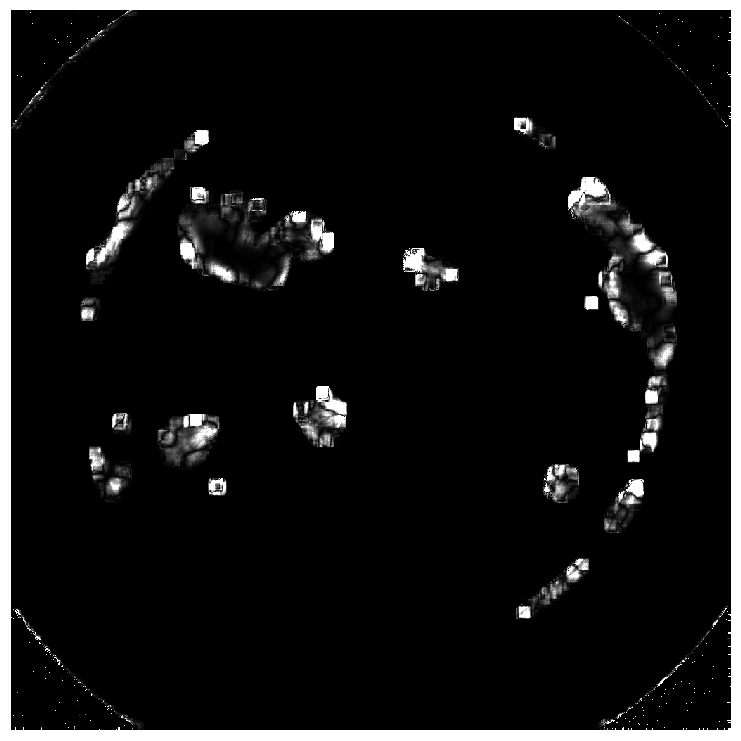

In [7]:

img = deepcopy(maskv)
img = np.abs(img)
img = np.amax(img,2)

fig = plt.figure(frameon=False)
fig.set_size_inches(10, 10)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
show_image(np.flipud(img), ax = ax)
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
fig.savefig(filenameN + 'fnSaliency_B&W.png', bbox_inches='tight', dpi = 103, pad_inches=0)

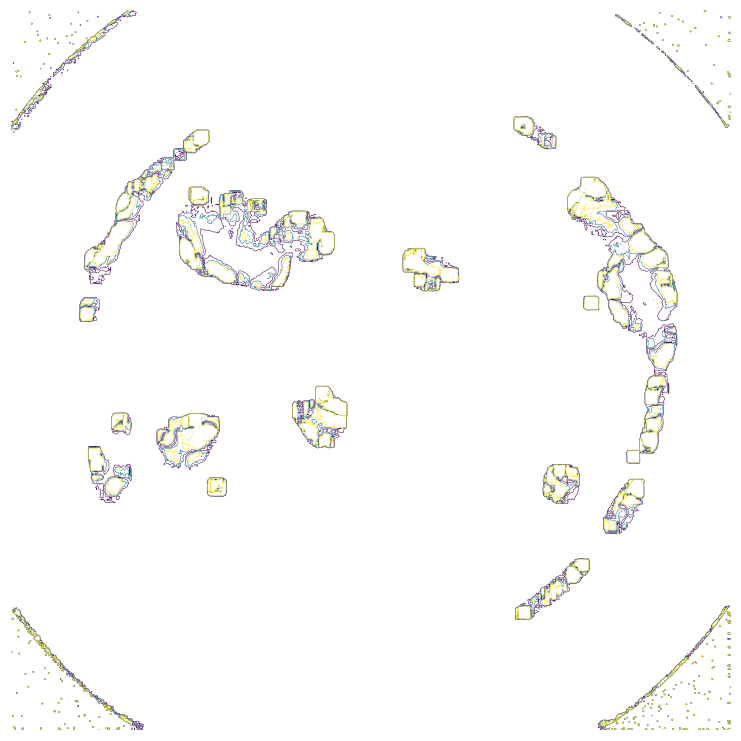

In [8]:
fig = plt.figure(frameon=False)
fig.set_size_inches(10, 10)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.contour(img,[0.0007, 0.002, 0.004], linewidths = 0.5)
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
#fig.savefig(filenameN + 'Saliency_Countour.png', bbox_inches='tight', dpi = 103, pad_inches=0)

In [9]:
#filename = '00000_AIA20120306_2324_8chnls_1024_060m'
filename = '00681_AIA20140213_0636_8chnls_1024_096m'
df = feather.read_dataframe('00000_AIA20120306_2324_8chnls_1024_060m' + '.fthr')

def deprocess_contrast_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()*1.9
    x /= (x.std() + 1e-5)/5
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

dfnp = df.values
dfnp = dfnp.reshape(1024,1024,8)
dfnp[dfnp<=0] = 1
#dfnp = np.log(dfnp)

afilter = deepcopy(dfnp)

afilter[:,:,6] = np.power(afilter[:,:,6],2)
afilter[:,:,0] = np.power(afilter[:,:,0],2)
afilter[:,:,1] = np.power(afilter[:,:,1],2)

afilter = deprocess_contrast_image(np.log10(afilter))

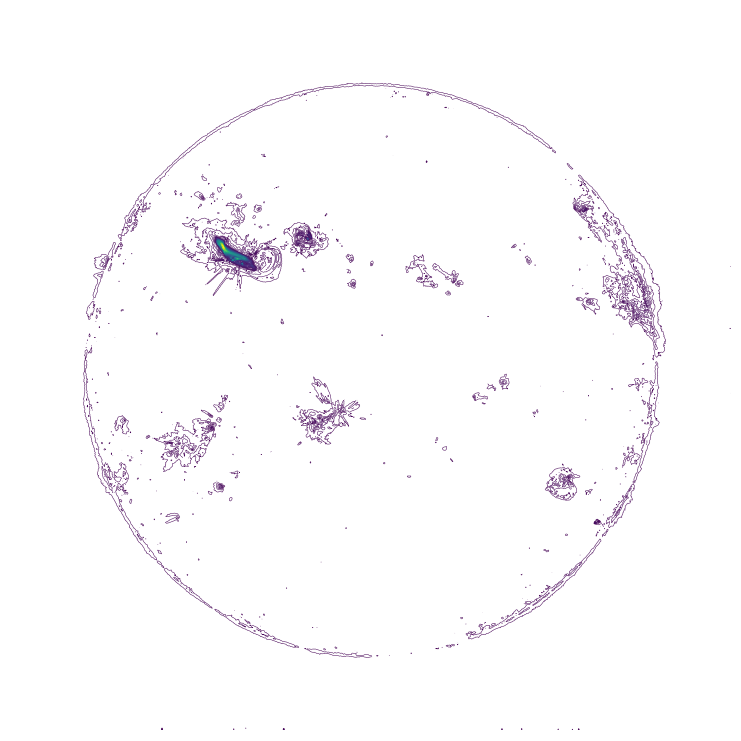

In [10]:
fig = plt.figure(frameon=False)
fig.set_size_inches(10, 10)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.contour(dfnp[:,:,1],200, linewidths = 0.5)
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')

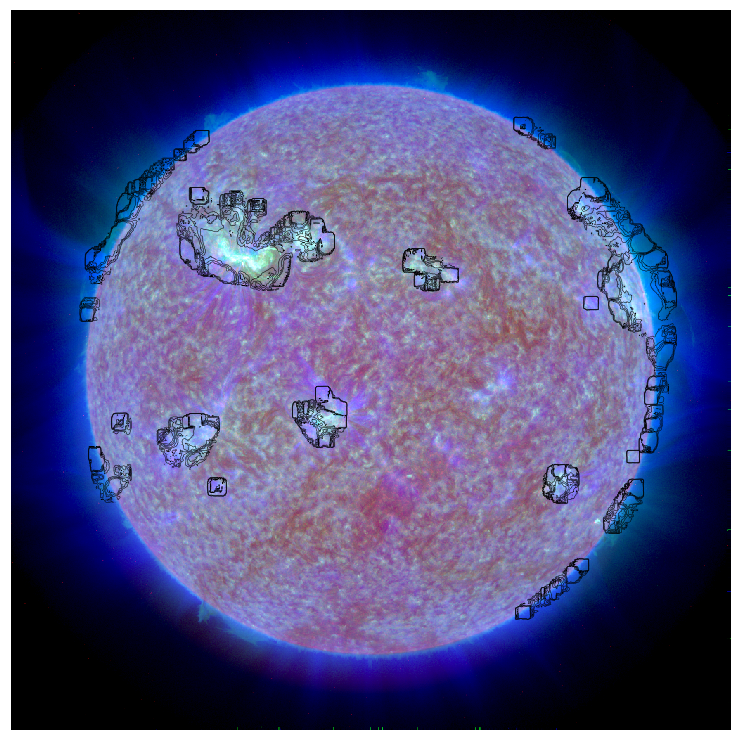

In [11]:
#Assemble composite 1

#1600
r = afilter[:,:,7]
#304
g = afilter[:,:,5]
#171
b = afilter[:,:,2]
    
rgb1 = np.dstack((r,g,b))


fig = plt.figure(frameon=False)
fig.set_size_inches(10, 10)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(np.flipud(rgb1))
ax.contour(np.flipud(img),[0.0008, 0.002, 0.004], linewidths = .5, colors = 'k')
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
fig.savefig(filenameN + '_1600_304_171_Saliency.png', bbox_inches='tight', dpi = 103, pad_inches=0)
plt.show()

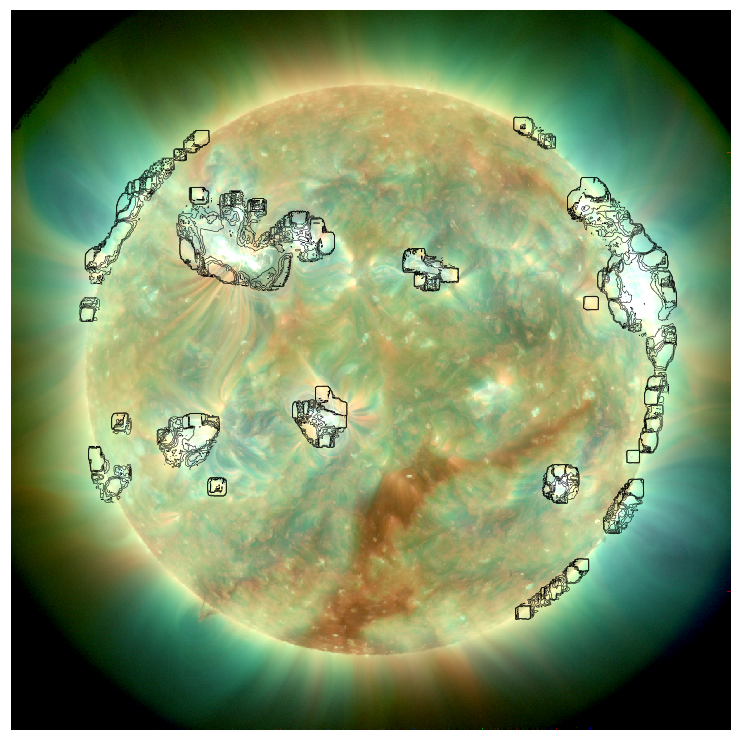

In [12]:
#Assemble composite 2

#171
r = afilter[:,:,2]
#193
g = afilter[:,:,3]
#211
b = afilter[:,:,4]

rgb1 = np.dstack((r,g,b))


fig = plt.figure(frameon=False)
fig.set_size_inches(10, 10)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(np.flipud(rgb1))
ax.contour(np.flipud(img),[0.0008, 0.002, 0.004], linewidths = .5, colors = 'k')
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
fig.savefig(filenameN + '_171_193_211_Saliency.png', bbox_inches='tight', dpi = 103, pad_inches=0)
plt.show()

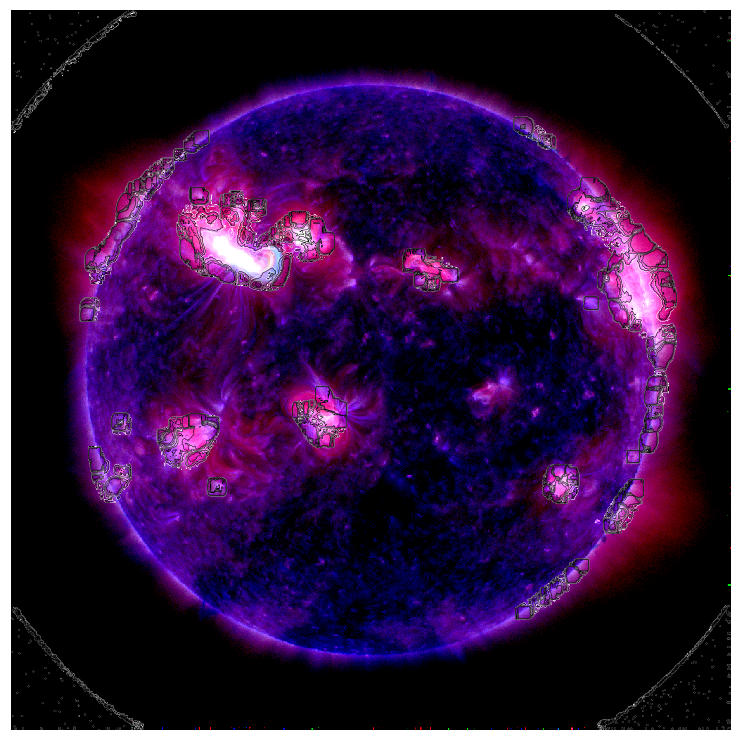

In [13]:
#Assemble composite 3

#335
r = afilter[:,:,6]
#94
g = afilter[:,:,0]
#131
b = afilter[:,:,1]

rgb1 = np.dstack((r,g,b))


fig = plt.figure(frameon=False)
fig.set_size_inches(10, 10)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(np.flipud(rgb1))
ax.contour(np.flipud(img),[0.0006,0.0009, 0.00175, 0.002, 0.004], linewidths = .5, colors = ('w','k','w','k','k'))
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
fig.savefig(filenameN + '_335_94_131_Saliency.png', bbox_inches='tight', dpi = 103, pad_inches=0)
plt.show()

# Guided backpropagation

In [12]:
custom_objects.append({"custom_loss":1})

AttributeError: 'dict' object has no attribute 'append'

In [5]:
from guided_backprop import GuidedBackprop
guided_bprop = GuidedBackprop(model, custom_objects=custom_objects) # A very expensive operation, which hackingly creates 2 new temp models

ValueError: Unknown layer: LogWhiten

In [ ]:
maskgb = guided_bprop.get_mask(img)
#show_image(mask, ax=plt.subplot('121'), title='guided backprop')

masksgb = guided_bprop.get_smoothed_mask(x[0])
#show_image(mask, ax=plt.subplot('122'), title='smoothed guided backprop')

# Integrated gradient

In [13]:
from integrated_gradients import IntegratedGradients
inter_grad = IntegratedGradients(model)

In [17]:
maskig = inter_grad.get_mask(dfnp)
#show_image(mask, ax=plt.subplot('121'), title='integrated grad')

masksig = inter_grad.get_smoothed_mask(dfnp)
#show_image(mask, ax=plt.subplot('122'), title='smoothed integrated grad')

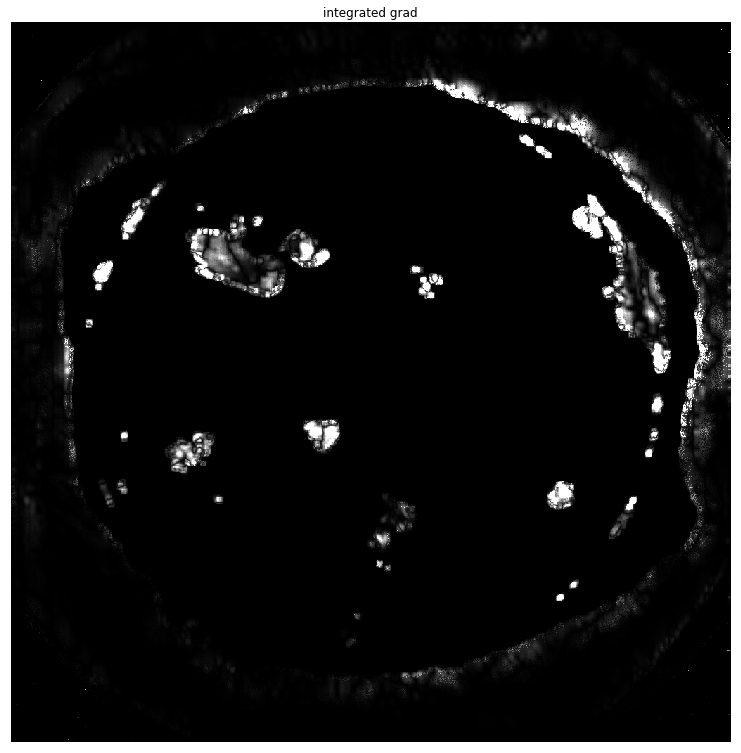

In [18]:
fig = plt.figure(frameon=False)
fig.set_size_inches(10, 10)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
show_image(np.flipud(maskig), ax = ax, title='integrated grad')
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')


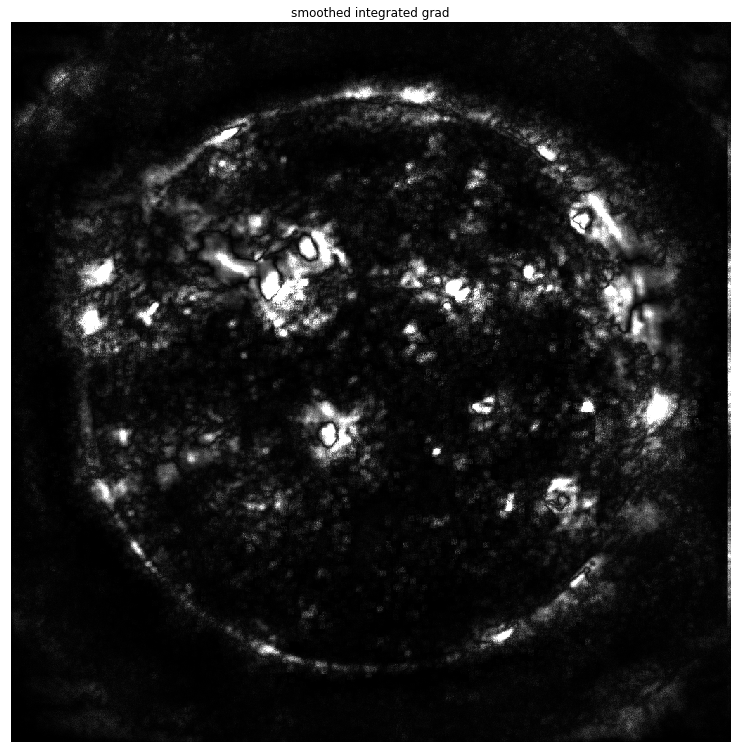

In [19]:
fig = plt.figure(frameon=False)
fig.set_size_inches(10, 10)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
show_image(np.flipud(masksig), ax = ax, title='smoothed integrated grad')
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')


# Visual backpropagation

In [5]:
from visual_backprop import VisualBackprop
visual_bprop = VisualBackprop(model)

In [6]:
maskvb = visual_bprop.get_mask(dfnp)
#show_image(mask, ax=plt.subplot('121'), title='visual backprop')

masksvb = visual_bprop.get_smoothed_mask(dfnp)
#show_image(mask, ax=plt.subplot('122'), title='smoothed visual backprop')

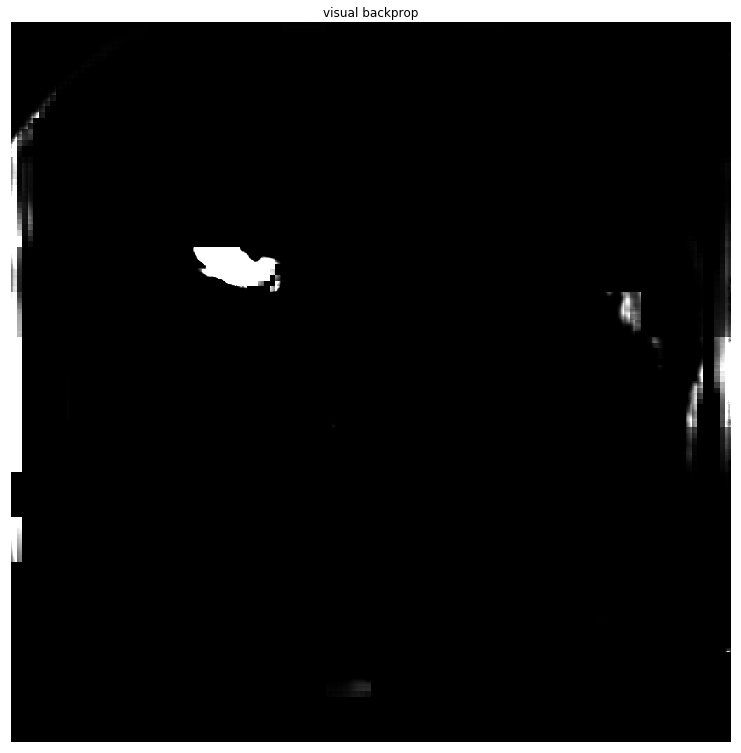

In [7]:
fig = plt.figure(frameon=False)
fig.set_size_inches(10, 10)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
show_image(np.flipud(maskvb), ax = ax, title='visual backprop')
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')


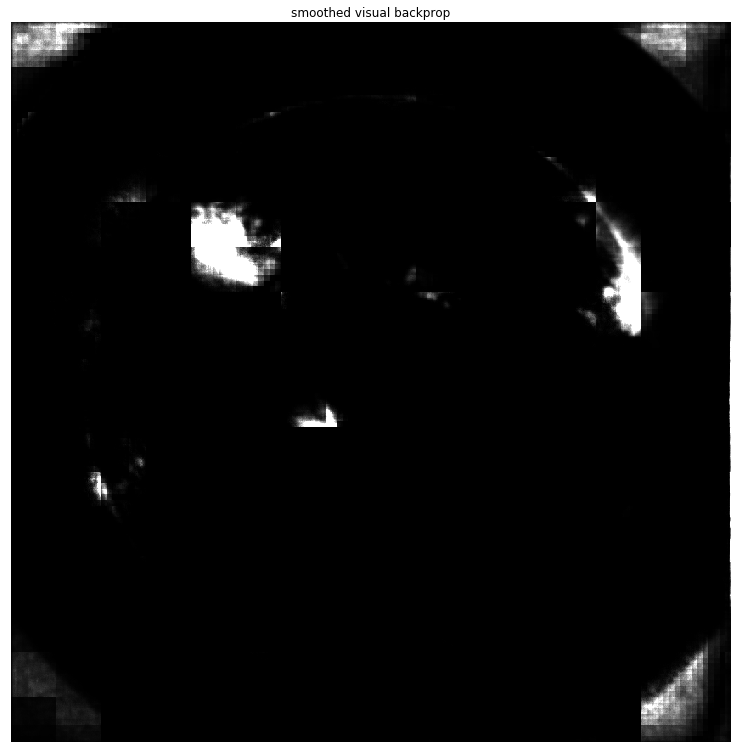

In [8]:
fig = plt.figure(frameon=False)
fig.set_size_inches(10, 10)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
show_image(np.flipud(masksvb), ax = ax, title='smoothed visual backprop')
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')


# Cross comparision

In [ ]:
plt.figure(figsize=(20,8))

# Plot non-smoothed versions
show_image(img, grayscale=False, ax=plt.subplot(251))

mask = vanilla.get_mask(img)
show_image(mask, ax=plt.subplot(252), title='vanilla gradient')

mask = guided_bprop.get_mask(img)
show_image(mask, ax=plt.subplot(253), title='guided backprop')

mask = inter_grad.get_mask(x[0])
show_image(mask, ax=plt.subplot(254), title='integrated grad')

mask = visual_bprop.get_mask(x[0])
show_image(mask, ax=plt.subplot(255), title='visual backprop')

# Plot smoothed versions
show_image(img, grayscale=False, ax=plt.subplot(256))

mask = vanilla.get_smoothed_mask(img)
show_image(mask, ax=plt.subplot(257), title='smoothed vanilla gradient')

mask = guided_bprop.get_smoothed_mask(img)
show_image(mask, ax=plt.subplot(258), title='smoothed guided backprop')

mask = inter_grad.get_smoothed_mask(x[0])
show_image(mask, ax=plt.subplot(259), title='smoothed integrated grad')

mask = visual_bprop.get_smoothed_mask(x[0])
show_image(mask, ax=plt.subplot(2,5,10), title='smoothed visual backprop')